In [288]:
# importing relevant packages

import pandas as pd
from hmmlearn.hmm import GaussianHMM
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig_dir = "./Figures/"
plt.rcParams["figure.facecolor"] = "w"

In [289]:
# loading the preprocessed dataset

all_conflicts = pd.read_csv("/Users/varshinisubramanian/Desktop/CMU/Yttri Lab Research/all_experiments_df_with_DTs.csv")

In [290]:
# extracting the no conflict, low volatility control data from the preprocessed dataset

No_conflict_low_volatility = all_conflicts.loc[(all_conflicts["conflict"]=="No")&(all_conflicts["volatility"]=="Low") & (all_conflicts["condition"].str.contains("Control"))] 

In [291]:
# finding each of the animal ids for which there are measurements for no conflict, no volatility

animal_ids = No_conflict_low_volatility['animal_id'].unique()
animal_ids

array([ 1,  2,  4,  5,  6,  7,  8,  9, 10])

In [292]:
# extracting the data one mouse at a time

mouse_indiv = No_conflict_low_volatility.loc[(No_conflict_low_volatility["animal_id"] == 9)]

In [293]:
# renaming decision time variable

mouse_indiv = mouse_indiv.rename({'RT(ms)': 'dec_time'}, axis=1)

In [294]:
block_change = []
dec_times = []
optimal_action = []

for session in mouse_indiv['session'].unique():
    #pulling out each out session of the mouse 
    df_session = mouse_indiv.loc[(mouse_indiv['session']) == session]
    df_session.reset_index(drop=True, inplace=True)

    # shifting decision time measurements down by 1 - this was not done in the processed dataset
    df_session['dec_time'] = df_session.dec_time.shift(1)

    # calculating decision time median + median absolute deviation per session
    dt_med = df_session['dec_time'].median()
    dt_mad = (df_session['dec_time'] - df_session['dec_time'].median()).abs().median()

    for index, row in df_session.iterrows():
        if index > 0:
            # checking if the mouse stayed/switched actions based on whether they were rewarded previously 
            # if they were rewarded and stayed, or if they were unrewarded and switched, this counted as the optimal action
            if row['chosen_action'] == df_session.loc[int(index) - 1, 'chosen_action'] and df_session.loc[int(index) - 1, 'rewarded_code'] == 1:
                optimal_action.append(1)
            elif row['chosen_action'] != df_session.loc[int(index) - 1, 'chosen_action'] and df_session.loc[int(index) - 1, 'rewarded_code'] == 0:
                optimal_action.append(1)
            else:
                optimal_action.append(0)

            # if row['chosen_action'] == df_session.loc[int(index) - 1, 'chosen_action']:
            #     optimal_action.append(1)
            # else: 
            #     optimal_action.append(0) 
            
            # checking to see if a block change happened
            if row['block'] == df_session.loc[int(index) - 1, 'block']:
                block_change.append(0)
            else:
                block_change.append(1)
            
            # normalizing the decision times based on median + median absolute deviation
            dec_times.append((row['dec_time'] - dt_med)/dt_mad)
        else: 
            # default values to denote the beginning of a session
            optimal_action.append(-1)
            block_change.append(1)
            dec_times.append(row['dec_time'])

/var/folders/mp/9lwthk5j5sjgylxrv66mspcc0000gn/T/ipykernel_25877/3140578082.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session['dec_time'] = df_session.dec_time.shift(1)
/var/folders/mp/9lwthk5j5sjgylxrv66mspcc0000gn/T/ipykernel_25877/3140578082.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session['dec_time'] = df_session.dec_time.shift(1)
/var/folders/mp/9lwthk5j5sjgylxrv66mspcc0000gn/T/ipykernel_25877/3140578082.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [295]:
# updating the dataset with the new values calculated above
mouse_indiv['optimal_action'] = optimal_action
mouse_indiv['block_change'] = block_change
mouse_indiv['dec_time'] = dec_times
mouse_indiv[['chosen_action', 'optimal_action', 'block', 'block_change', 'rewarded_code', 'dec_time']]

,chosen_action,optimal_action,block,block_change,rewarded_code,dec_time
206437,right,-1,left,1,0,NaN
206438,right,0,left,0,0,-0.866795
206439,right,0,left,0,0,-0.916988
206440,right,0,left,0,0,0.001931
206441,right,0,left,0,0,0.187259
...,...,...,...,...,...,...
210461,right,1,right,0,1,5.097015
210462,left,0,right,0,0,-0.946269
210463,left,0,right,0,0,-0.516418
210464,left,0,right,0,0,-0.311940


In [296]:
# extracting all the values for session 0 for this mouse - storing this in a csv file for future analysis

session_0_full = mouse_indiv.loc[mouse_indiv['revised_session_id_x'] == 0]
session_0_full.to_csv('/Users/varshinisubramanian/Desktop/CMU/Yttri Lab Research/No Conflict Low Volatility (control)/CSV Files/session_0_full_mouse9.csv')

In [297]:
# removing all the first trials of a session

mouse_indiv = mouse_indiv.loc[mouse_indiv['optimal_action'] != -1]
mouse_indiv

,Unnamed: 0,level_0,index,conflict,condition,volatility,event_marker,block,reward_probability,trial_length_range,...,rewarded,animal_id,chnc,optimal_action,revised_session_id_x,dec_time,revised_session_id_y,rewarded_code,conflict + volatility,block_change
206438,206438,1,23402,No,iSPN-Control,Low,8.0,left,0-90,20-30,...,unrewarded,9,52,0,0,-0.866795,0,0,No - Low,0
206439,206439,2,23403,No,iSPN-Control,Low,8.0,left,0-90,20-30,...,unrewarded,9,75,0,0,-0.916988,0,0,No - Low,0
206440,206440,3,23404,No,iSPN-Control,Low,8.0,left,0-90,20-30,...,unrewarded,9,79,0,0,0.001931,0,0,No - Low,0
206441,206441,4,23405,No,iSPN-Control,Low,8.0,left,0-90,20-30,...,unrewarded,9,88,0,0,0.187259,0,0,No - Low,0
206442,206442,5,23406,No,iSPN-Control,Low,1.0,left,0-90,20-30,...,rewarded,9,71,1,0,0.998069,0,1,No - Low,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210461,210461,4024,27581,No,iSPN-Control,Low,5.0,right,0-90,20-30,...,rewarded,9,59,1,5,5.097015,5,1,No - Low,0
210462,210462,4025,27582,No,iSPN-Control,Low,4.0,right,0-90,20-30,...,unrewarded,9,67,0,5,-0.946269,5,0,No - Low,0
210463,210463,4026,27583,No,iSPN-Control,Low,4.0,right,0-90,20-30,...,unrewarded,9,97,0,5,-0.516418,5,0,No - Low,0
210464,210464,4027,27584,No,iSPN-Control,Low,4.0,right,0-90,20-30,...,unrewarded,9,81,0,5,-0.311940,5,0,No - Low,0


In [298]:
# calculating exponentially weighted moving averages for optimal action and reward, across a span of 4 trials

optimal_action_mv = []
reward_mv = []

for session in mouse_indiv['session'].unique():
    df_session = mouse_indiv.loc[(mouse_indiv['session']) == session]
    df_session.reset_index(drop=True, inplace=True)
    
    oa = df_session['optimal_action'].ewm(span=4).mean()
    rew = df_session['rewarded_code'].ewm(span=4).mean()

    optimal_action_mv.extend(oa.tolist())
    reward_mv.extend(rew.tolist())

In [299]:
# updating dataset with new calculated values

mouse_indiv['optimal_action_mv'] = optimal_action_mv
mouse_indiv['reward_mv'] = reward_mv
mouse_indiv[['chosen_action', 'optimal_action', 'optimal_action_mv', 'block', 'block_change', 'reward_mv', 'rewarded_code', 'dec_time']]

,chosen_action,optimal_action,optimal_action_mv,block,block_change,reward_mv,rewarded_code,dec_time
206438,right,0,0.000000,left,0,0.000000,0,-0.866795
206439,right,0,0.000000,left,0,0.000000,0,-0.916988
206440,right,0,0.000000,left,0,0.000000,0,0.001931
206441,right,0,0.000000,left,0,0.000000,0,0.187259
206442,left,1,0.433727,left,0,0.433727,1,0.998069
...,...,...,...,...,...,...,...,...
210461,right,1,0.613225,right,0,0.524588,1,5.097015
210462,left,0,0.367935,right,0,0.314753,0,-0.946269
210463,left,0,0.220761,right,0,0.188852,0,-0.516418
210464,left,0,0.132457,right,0,0.113311,0,-0.311940


In [300]:
# removing outlier decision times

mouse_indiv = mouse_indiv.loc[mouse_indiv["dec_time"]<=np.percentile(mouse_indiv["dec_time"], 95)]
len(mouse_indiv)

3821

In [301]:
# calculating a moving average of decision times without outliers, across a span of 4 trials

dec_times_mv = []

for session in mouse_indiv['session'].unique():
    df_session = mouse_indiv.loc[(mouse_indiv['session']) == session]
    df_session.reset_index(drop=True, inplace=True)
    
    dts = df_session['dec_time'].ewm(span=4).mean()

    dec_times_mv.extend(dts.tolist())

In [302]:
# updating the dataset

mouse_indiv['dec_time_mv'] = dec_times_mv
mouse_indiv[['chosen_action', 'optimal_action', 'optimal_action_mv', 'block', 'block_change', 'reward_mv', 'rewarded_code', 'dec_time', 'dec_time_mv']]

/var/folders/mp/9lwthk5j5sjgylxrv66mspcc0000gn/T/ipykernel_25877/3971358562.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_indiv['dec_time_mv'] = dec_times_mv


,chosen_action,optimal_action,optimal_action_mv,block,block_change,reward_mv,rewarded_code,dec_time,dec_time_mv
206438,right,0,0.000000,left,0,0.000000,0,-0.866795,-0.866795
206439,right,0,0.000000,left,0,0.000000,0,-0.916988,-0.898166
206440,right,0,0.000000,left,0,0.000000,0,0.001931,-0.438933
206441,right,0,0.000000,left,0,0.000000,0,0.187259,-0.151161
206442,left,1,0.433727,left,0,0.433727,1,0.998069,0.347291
...,...,...,...,...,...,...,...,...,...
210461,right,1,0.613225,right,0,0.524588,1,5.097015,1.661268
210462,left,0,0.367935,right,0,0.314753,0,-0.946269,0.618253
210463,left,0,0.220761,right,0,0.188852,0,-0.516418,0.164385
210464,left,0,0.132457,right,0,0.113311,0,-0.311940,-0.026145


In [303]:
# creating storage variables for finding the number of states

store_score = dict()
store_score["num_states"] = []
store_score["bic"] = []
store_score["score"] = []
store_score["trials"] = []

num_c_array = np.arange(2,13) # numbers of potential states
folds = 5 # number of dataset splits


best_score = best_states = None
full_data = mouse_indiv[["dec_time_mv", "optimal_action_mv", "reward_mv"]].to_numpy() # features that we are training on

In [304]:
# splitting dataset into k folds for training

action_copy = np.copy(full_data)
np.random.shuffle(action_copy)
dataset_split = np.array_split(action_copy, folds)

In [305]:
np.concatenate(dataset_split).shape

(3821, 3)

In [333]:
best_score = num_states = best_model = None
    
bic_store = np.zeros((len(num_c_array), folds))
score_store = np.zeros((len(num_c_array), folds))
for i,state in enumerate(num_c_array):
    
    for j,split in enumerate(dataset_split):
        # splitting into train and validate based on the previous splitting of the data
        X_validate = split
        X_train = np.concatenate([k for l,k in enumerate(dataset_split) if l != j])
        
        model = GaussianHMM(covariance_type='full', n_components=state,tol=0.01,n_iter=200)#params='ste', init_params='ste')
        model.fit(X_train) # training the model
        bic = model.bic(X_validate) # finding the BIC based on validation data
        score = model.score(X_validate) # finding the score based on validation data

        # tracking bic and score
        store_score['bic'].append(bic)
        store_score['score'].append(score)
        store_score['num_states'].append(state)
        
        bic_store[i][j] = bic
        score_store[i][j] = score
        
# best score == average over 5 folds
best_bic = np.mean(bic_store, axis=1)
best_score = np.mean(score_store, axis=1)

[Text(0.5, 0, 'Number of States (Offset by 2)'), Text(0, 0.5, 'BIC Value')]

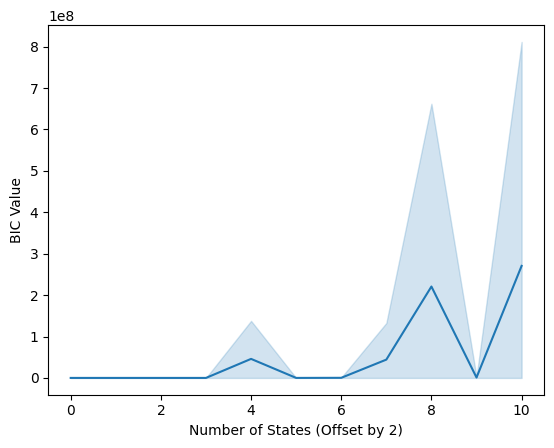

In [334]:
# plotting the BIC values for different numbers of states, to see where BIC is minimized

bic_store_df = pd.DataFrame.from_records(bic_store.T).reset_index()
bic_store_df = bic_store_df.rename(columns={'index':'folds'})
bic_store_melted = bic_store_df.melt(id_vars='folds')
ax = sns.lineplot(data=bic_store_melted, x='variable', y='value')
ax.set(xlabel='Number of States (Offset by 2)', ylabel='BIC Value')

<Axes: xlabel='variable', ylabel='value'>

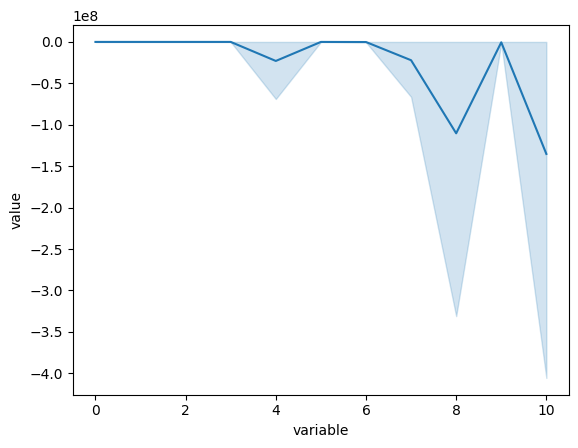

In [335]:
# plotting the score values for different numbers of states, to see where score is maximized

score_store_df = pd.DataFrame.from_records(score_store.T).reset_index()
score_store_df = score_store_df.rename(columns={'index':'folds'})
score_store_melted = score_store_df.melt(id_vars='folds')
sns.lineplot(data=score_store_melted, x='variable', y='value')

In [338]:
# fitting a model on the full data, after determining the best number of states

best_model = GaussianHMM(covariance_type='full', n_components=5,tol=0.01,n_iter=300 )#params='ste', init_params='ste')
best_model.fit(full_data)
print(f"Means: {best_model.means_}")
        
real_states = best_model.predict(full_data)#.reshape(-1, 1))
mouse_indiv["state"] = real_states

Means: [[0.17408234 0.98815119 0.98786268]
 [0.10905774 0.68174037 0.51052857]
 [0.16849977 0.59505897 0.59413449]
 [0.20285418 0.94333734 0.92651074]
 [0.12700123 0.87470243 0.47400922]]


/var/folders/mp/9lwthk5j5sjgylxrv66mspcc0000gn/T/ipykernel_25877/780214883.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_indiv["state"] = real_states


[Text(0.5, 0, 'Probability of Optimal Action'),
 Text(0, 0.5, 'Probability of Reward')]

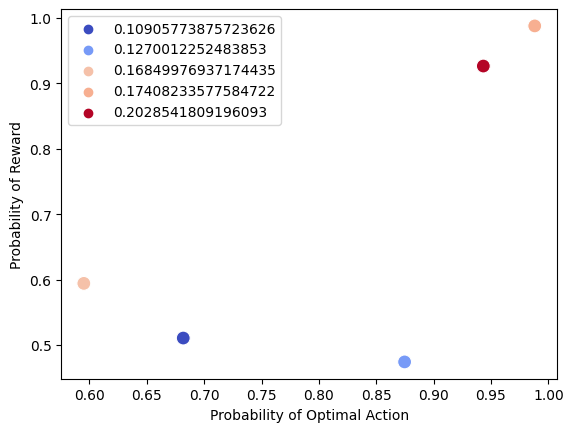

In [339]:
# plotting the state means as a 2d scatterplot, with decision time as a hue

g = sns.scatterplot(
    x=best_model.means_[:, 1], y=best_model.means_[:, 2], hue=best_model.means_[:, 0], s=100, palette="coolwarm"
    #,hue_norm=(0, 1)
    # palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    # height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

g.set(xlabel="Probability of Optimal Action", ylabel="Probability of Reward")

Text(0.5, 0, 'Probability of Reward')

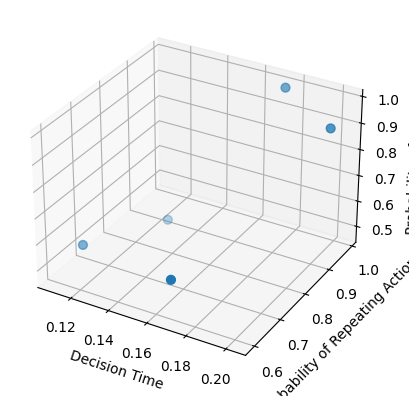

In [340]:
# plotting the state means as a 3d scatterplot

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(best_model.means_[:, 0], best_model.means_[:, 1], best_model.means_[:, 2], s=40)
ax.set_xlabel('Decision Time')
ax.set_ylabel('Probability of Repeating Action')
ax.set_zlabel('Probability of Reward')

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


0
1
2
3
4


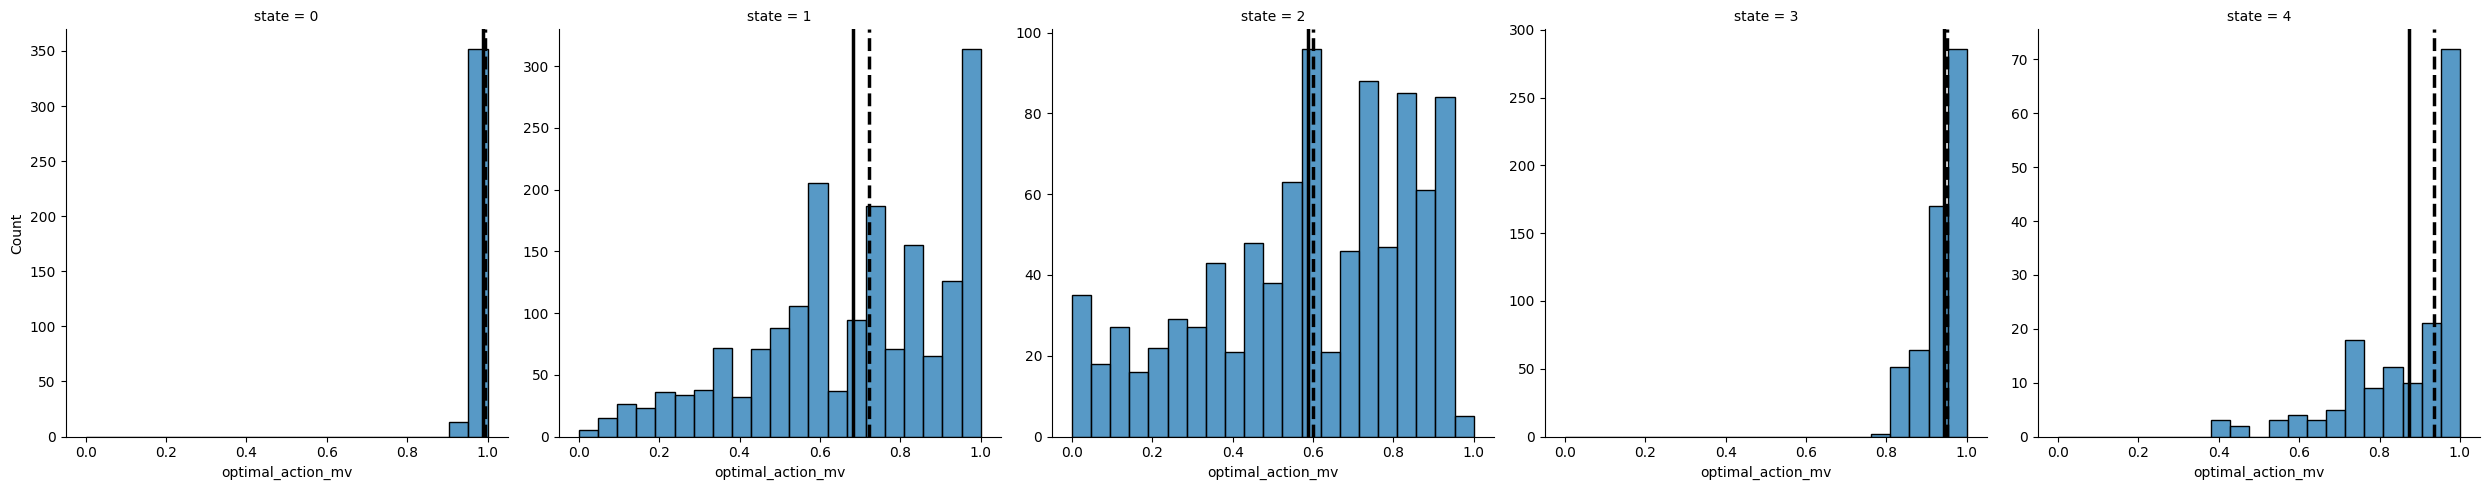

In [341]:
# plotting the distribution of values for each state

m1 = mouse_indiv.groupby('state').optimal_action_mv.agg(['mean', 'median'])

g = sns.displot(
    data=mouse_indiv, x='optimal_action_mv',
    col='state',  
    facet_kws=dict(sharey=False, sharex=False)
)
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    spec = ax.get_title().split(' = ')[1]
    print(spec)
    # select the data for the species
    data = m1.loc[int(spec), :]    
    # plot the lines
    ax.axvline(x=data['mean'], c='k', ls='-', lw=2.5)
    ax.axvline(x=data['median'], c='k', ls='--', lw=2.5)

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


0
1
2
3
4


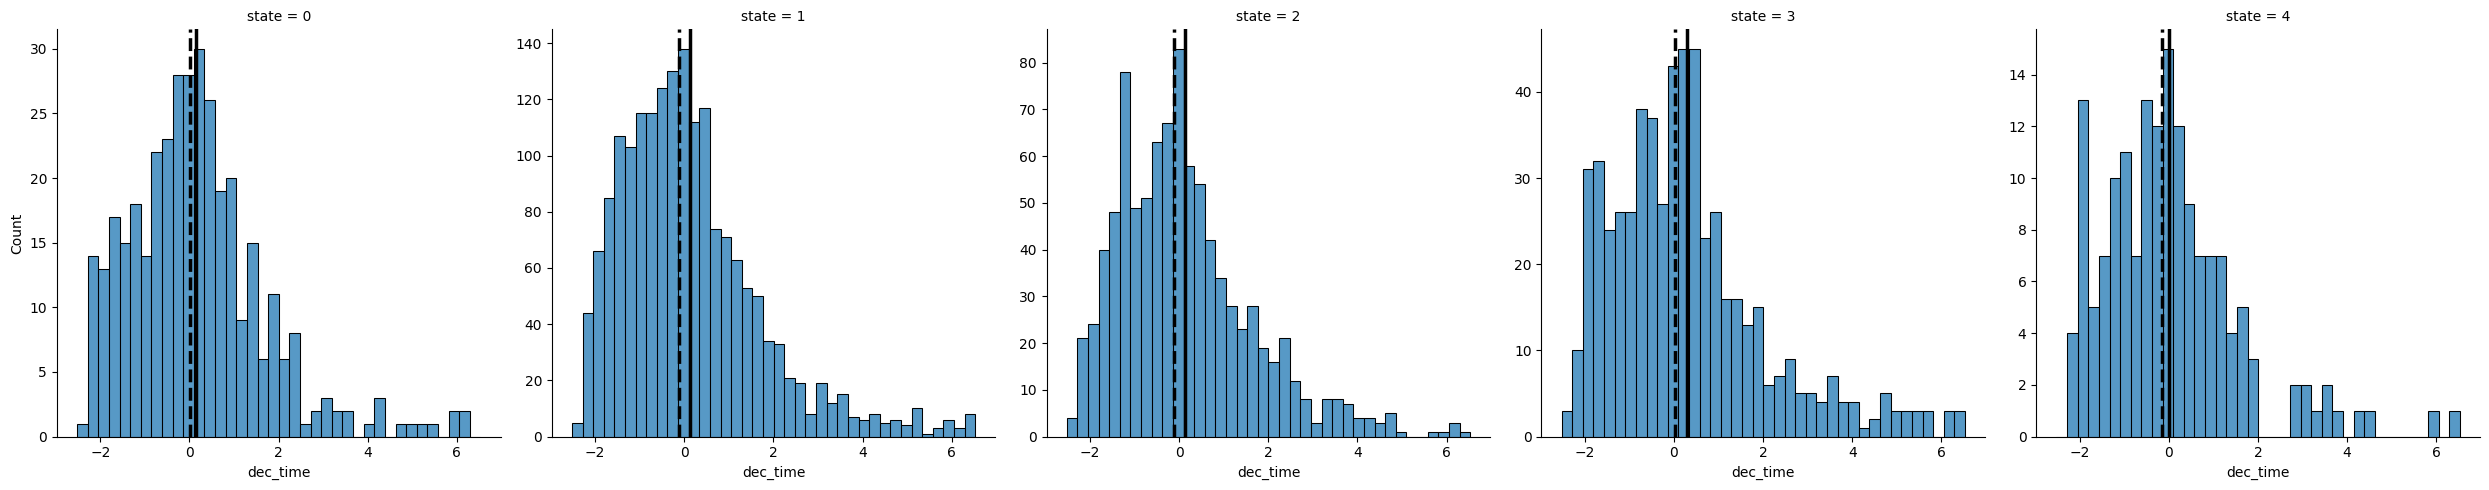

In [342]:
# plotting the distribution of values for each state

m2 = mouse_indiv.groupby('state').dec_time.agg(['mean', 'median'])

g = sns.displot(
    data=mouse_indiv, x='dec_time',
    col='state',  
    facet_kws=dict(sharey=False, sharex=False)
)
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    spec = ax.get_title().split(' = ')[1]
    print(spec)
    # select the data for the species
    data = m2.loc[int(spec), :]    
    # plot the lines
    ax.axvline(x=data['mean'], c='k', ls='-', lw=2.5)
    ax.axvline(x=data['median'], c='k', ls='--', lw=2.5)

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


0
1
2
3
4


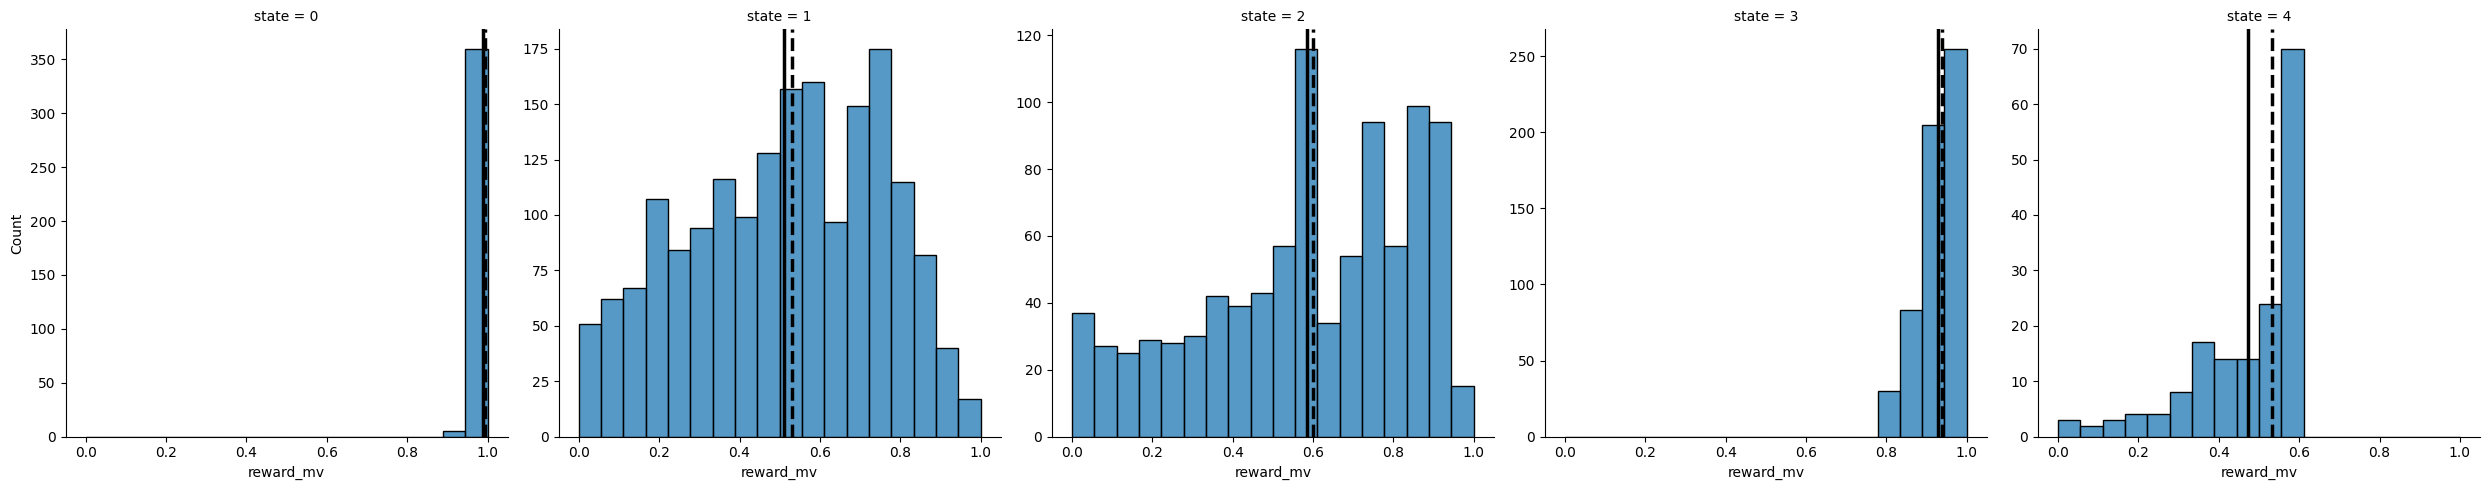

In [343]:
# plotting the distribution of values for each state

m3 = mouse_indiv.groupby('state').reward_mv.agg(['mean', 'median'])

g = sns.displot(
    data=mouse_indiv, x='reward_mv',
    col='state',  
    facet_kws=dict(sharey=False, sharex=False)
)
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    spec = ax.get_title().split(' = ')[1]
    print(spec)
    # select the data for the species
    data = m3.loc[int(spec), :]    
    # plot the lines
    ax.axvline(x=data['mean'], c='k', ls='-', lw=2.5)
    ax.axvline(x=data['median'], c='k', ls='--', lw=2.5)

<Axes: >

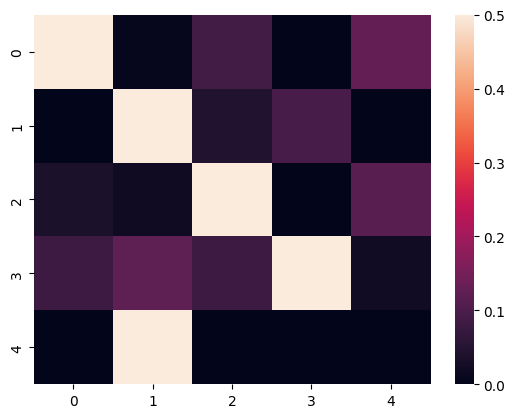

In [344]:
# plotting the transition matrix

sns.heatmap(best_model.transmat_, vmin=0, vmax=0.5)

In [345]:
# proportion of time spent in each state

normalized_counts = mouse_indiv['state'].value_counts(normalize=True)
normalized_counts

state
1    0.471081
2    0.240775
3    0.149961
0    0.095525
4    0.042659
Name: proportion, dtype: float64

In [346]:
import dill

dill.dump_session('/Users/varshinisubramanian/Desktop/CMU/Yttri Lab Research/No Conflict Low Volatility (control)/Mouse Runs (pt. 2)/mouse_9_run.db')

In [347]:
session_0_full = mouse_indiv.loc[mouse_indiv['revised_session_id_x'] == 0]
session_0_full.to_csv('/Users/varshinisubramanian/Desktop/CMU/Yttri Lab Research/No Conflict Low Volatility (control)/CSV Files/session_0_mouse9.csv')